In [152]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split

from sksurv.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [153]:
df = pd.read_csv('imputedReadmission.csv')
df = df.drop(axis=1, columns=['Unnamed: 0'], inplace=False)

#cleaning

colCats = {
    'admInfo': ['subject_id', 'hadm_id', 'stay_id'],
    'ptInfoCont': ['age', 'height', 'weight'],
    'demographics': ['gender','ethnicity','marital_status','insurance','language'],
    'admCat': ['first_careunit','last_careunit','admission_location','admission_type', 'dbsource'],
    'admTime': ['admittime', 'dischtime', 'intime', 'outtime', 'reint_time', 'ext_time', 'postop_intime', 'deathtime', 'dod'],
    'admNum': ['los','icustay_seq'],
    'markersTs': ['aki', 'ph', 'bicarb', 'baseexcess', 'chloride', 'free_calcium', 'glucose', 'potassium', 'sodium', 'lactate', 
                  'hematocrit', 'hb', 'pco2', 'po2', 'bg_temp', 'fio2', 'ventrate', 'tidalvol', 'aado2', 'specimen', 'neutrophils', 
                  'lymphocytes', 'wcc', 'plt', 'crp', 'albumin', 'creatinine', 'bun', 'magnesium', 'alt', 'alp', 'ast', 'ggt', 
                  'bilirubin_total', 'bilirubin_direct', 'bilirubin_indirect', 'inr', 'fibrinogen', 'bleed_time', 'ptt', 'pt', 'hba1c', 'prbc', 'plts', 'ffp', 'cryo'],
    'procedureType': ['aortic','mitral','tricuspid','pulmonary','cabg'],
    'comorbids': ['liver_severe','liver_mild','rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd',
                      'paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi','dementia'],
    'diabUnits': ['diab_un', 'diab_cc'],
    'otherTs': ['dtoutput', 'echo', 'fluid', 'infection', 'intropes', 'insulin', 'pasp', 'padp', 'mpap', 'vent_array'],
    'vitalsTs': ['hr', 'sbp', 'dbp', 'meanbp', 'rr', 'temp', 'spo2', 'cardiac_index'],
    'misc': ['sofa', 'reintubation'],
    'readmitInfo': ['readmit_times', 'readmissions', 'first_readmission'],
    'ventTimes': ['int_time1', 'ext_time1', 'duration1', 'int_time2', 'ext_time2', 'duration2'],
    'icuStayInfo': ['icu_stay_hrs']
}
colCatsSquashed = [j for k in [colCats[i] for i in colCats] for j in k]

#print uncategorised and/or unaccounted columns
print([i for i in df.columns if i not in colCatsSquashed]) # in df but not in categories
print([i for i in colCatsSquashed if i not in df.columns]) # in categories but not in df


['ph_mean', 'ph_max', 'ph_min', 'bicarb_mean', 'bicarb_max', 'bicarb_min', 'baseexcess_mean', 'baseexcess_max', 'baseexcess_min', 'chloride_mean', 'chloride_max', 'chloride_min', 'free_calcium_mean', 'free_calcium_max', 'free_calcium_min', 'glucose_mean', 'glucose_max', 'glucose_min', 'potassium_mean', 'potassium_max', 'potassium_min', 'sodium_mean', 'sodium_max', 'sodium_min', 'lactate_mean', 'lactate_max', 'lactate_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'hb_mean', 'hb_max', 'hb_min', 'pco2_mean', 'pco2_max', 'pco2_min', 'po2_mean', 'po2_max', 'po2_min', 'wcc_mean', 'wcc_max', 'wcc_min', 'plt_mean', 'plt_max', 'plt_min', 'creatinine_mean', 'creatinine_max', 'creatinine_min', 'bun_mean', 'bun_max', 'bun_min', 'magnesium_mean', 'magnesium_max', 'magnesium_min', 'inr_mean', 'inr_max', 'inr_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'hba1c_mean', 'hba1c_max', 'hba1c_min', 'prbc_mean', 'prbc_max', 'prbc_min', 'hr_mean', 'hr_max', 'hr_min', 'sbp_mean', 'sbp_max', 'sbp_min

In [154]:
# target variable: icu stay duration
data_y_raw = []
for i in range(df.shape[0]):
    if pd.isnull(df['readmissions'][i]):
        censor = False
        time = (dt.datetime.strptime(df['dischtime'][i], "%Y-%m-%d %H:%M:%S") - dt.datetime.strptime(df['outtime'][i], "%Y-%m-%d %H:%M:%S")).total_seconds()/86400
    else:
        censor = True
        col = (dt.datetime.strptime(df['first_readmission'][i], "%Y-%m-%dT%H:%M:%S") - dt.datetime.strptime(df['outtime'][i], "%Y-%m-%d %H:%M:%S")).total_seconds()/86400
    data_y_raw.append((censor, time))
data_y = np.array(data_y_raw, dtype=[('Status', '?'), ('Hrs_to_readmit', '<f8')])
data_y

array([(False, 10.96018519), (False,  6.41016204), (False,  1.93519676),
       ..., (False,  2.91640046), (False,  2.85641204),
       (False,  2.99731481)],
      dtype=[('Status', '?'), ('Hrs_to_readmit', '<f8')])

Text(0.5, 0, 'time $t$')

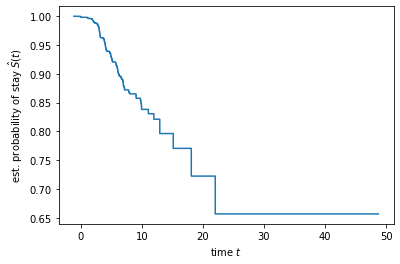

In [155]:
%matplotlib inline

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Hrs_to_readmit"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of stay $\hat{S}(t)$")
plt.xlabel("time $t$")

In [156]:
# one hot encodes categorical variables and removes columns related to irrelevant stuff
data_x = df[[i for i in df.columns if i not in [*colCats['readmitInfo'], *colCats['admTime'], *colCats['admInfo'], *colCats['admCat'], 
                                                'int_time1', 'ext_time1', 'int_time2', 'ext_time2', 'duration1', 'duration2', 'icustay_seq',
                                                't1dm', 't2dm', 'los'] and '_min' not in i and '_max' not in i]]
print(data_x.columns.to_list())

for i in data_x.columns:
    if data_x[i].dtype == 'object':
        data_x[i] = data_x[i].astype('category')

# colCats = {
#     'admInfo': ['subject_id', 'hadm_id', 'stay_id'],
#     'ptInfoCont': ['age', 'height', 'weight'],
#     'demographics': ['gender','ethnicity','marital_status','insurance','language'],
#     'admCat': ['first_careunit','last_careunit','admission_location','admission_type', 'dbsource'],
#     'admTime': ['admittime', 'dischtime', 'intime', 'outtime', 'reint_time', 'ext_time', 'postop_intime', 'deathtime', 'dod'],
#     'admNum': ['los','icustay_seq'],
#     'markersTs': ['aki', 'ph', 'bicarb', 'baseexcess', 'chloride', 'free_calcium', 'glucose', 'potassium', 'sodium', 'lactate', 
#                   'hematocrit', 'hb', 'pco2', 'po2', 'bg_temp', 'fio2', 'ventrate', 'tidalvol', 'aado2', 'specimen', 'neutrophils', 
#                   'lymphocytes', 'wcc', 'plt', 'crp', 'albumin', 'creatinine', 'bun', 'magnesium', 'alt', 'alp', 'ast', 'ggt', 
#                   'bilirubin_total', 'bilirubin_direct', 'bilirubin_indirect', 'inr', 'fibrinogen', 'bleed_time', 'ptt', 'pt', 'hba1c', 'prbc', 'plts', 'ffp', 'cryo'],
#     'procedureType': ['aortic','mitral','tricuspid','pulmonary','cabg'],
#     'comorbids': ['liver_severe','liver_mild','rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd',
#                       'paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi','dementia'],
#     'diabUnits': ['diab_un', 'diab_cc'],
#     'otherTs': ['dtoutput', 'echo', 'fluid', 'infection', 'intropes', 'insulin', 'pasp', 'padp', 'mpap', 'vent_array'],
#     'vitalsTs': ['hr', 'sbp', 'dbp', 'meanbp', 'rr', 'temp', 'spo2', 'cardiac_index'],
#     'misc': ['sofa', 'reintubation'],
#     'readmitInfo': ['readmit_times', 'readmissions', 'first_readmission'],
#     'ventTimes': ['int_time1', 'ext_time1', 'duration1', 'int_time2', 'ext_time2', 'duration2'],
#     'icuStayInfo': ['icu_stay_hrs']
# }

['ph_mean', 'bicarb_mean', 'baseexcess_mean', 'chloride_mean', 'free_calcium_mean', 'glucose_mean', 'potassium_mean', 'sodium_mean', 'lactate_mean', 'hematocrit_mean', 'hb_mean', 'pco2_mean', 'po2_mean', 'wcc_mean', 'plt_mean', 'creatinine_mean', 'bun_mean', 'magnesium_mean', 'inr_mean', 'ptt_mean', 'hba1c_mean', 'prbc_mean', 'hr_mean', 'sbp_mean', 'dbp_mean', 'meanbp_mean', 'rr_mean', 'temp_mean', 'spo2_mean', 'cardiac_index_mean', 'dtoutput_mean', 'pasp_mean', 'padp_mean', 'mpap_mean', 'abx_no', 'abx_bool', 'aki_stage_creat_mean', 'aki_stage_uo_mean', 'age', 'gender', 'ethnicity', 'height', 'weight', 'insurance', 'marital_status', 'language', 'sofa', 'cabg', 'aortic', 'mitral', 'tricuspid', 'pulmonary', 'mi', 'arrhythmia', 'ccf', 'pvd', 'cvd', 'dementia', 'copd', 'rheum', 'pud', 'liver_mild', 'paraplegia', 'ckd', 'malig', 'liver_severe', 'met_ca', 'aids', 'smoking', 'reintubation', 'icu_stay_hrs']


C:\Users\zhepu\AppData\Local\Temp/ipykernel_21832/3325309753.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x[i] = data_x[i].astype('category')


In [157]:
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric

,ph_mean,bicarb_mean,baseexcess_mean,chloride_mean,free_calcium_mean,glucose_mean,potassium_mean,sodium_mean,lactate_mean,hematocrit_mean,hb_mean,pco2_mean,po2_mean,wcc_mean,plt_mean,creatinine_mean,bun_mean,magnesium_mean,inr_mean,ptt_mean,hba1c_mean,prbc_mean,hr_mean,sbp_mean,dbp_mean,meanbp_mean,rr_mean,temp_mean,spo2_mean,cardiac_index_mean,dtoutput_mean,pasp_mean,padp_mean,mpap_mean,abx_no,abx_bool,aki_stage_creat_mean,aki_stage_uo_mean,age,gender=M,ethnicity=black,ethnicity=hispanic,ethnicity=native,ethnicity=other,ethnicity=white,height,weight,insurance=Medicaid,insurance=Medicare,insurance=Private,insurance=Self Pay,marital_status=LIFE PARTNER,marital_status=MARRIED,marital_status=SEPARATED,marital_status=SINGLE,marital_status=WIDOWED,language=*BEN,language=*FIL,language=*GUJ,language=*LEB,language=ALBA,language=AMER,language=ARAB,language=CAMB,language=CANT,language=CAPE,language=ENGL,language=ETHI,language=GERM,language=GREE,language=HAIT,language=HIND,language=ITAL,language=JAPA,language=KORE,language=MAND,language=PERS,language=POLI,language=PORT,language=PTUN,language=RUSS,language=SPAN,language=THAI,language=TURK,language=URDU,language=VIET,sofa,cabg,aortic,mitral,tricuspid,pulmonary,mi,arrhythmia,ccf,pvd,cvd,dementia,copd,rheum,pud,liver_mild,paraplegia,ckd,malig,liver_severe,met_ca,aids,smoking,reintubation,icu_stay_hrs
0,7.343333,26.000000,0.000000,107.000000,1.176667,121.518519,4.466667,138.000000,1.100000,27.666667,9.500000,47.500000,0.000000,19.100000,332.500000,0.550000,9.500000,2.150000,1.300000,41.900000,7.6,375.000000,93.066667,100.160714,53.339286,65.633333,18.666667,37.526570,98.185185,2.786307,28.000000,26.421875,15.409091,25.727273,1,1,0.00,0.700000,19,0.0,0.0,0.0,0.0,0.0,1.0,170.18,115.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.705556
1,7.352000,21.500000,-2.400000,113.666667,1.246667,101.000000,3.720000,139.000000,2.650000,22.000000,7.933333,39.800000,-2.400000,11.900000,155.500000,0.450000,9.000000,1.800000,1.700000,34.650000,10.8,211.944450,90.666667,110.617647,56.180556,74.486821,22.868750,37.644117,98.689655,2.790728,28.181818,23.480000,4.280000,11.760000,1,1,0.00,0.000000,21,0.0,0.0,1.0,0.0,0.0,0.0,152.40,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21.239444
2,7.380000,24.000000,-1.500000,107.000000,1.150000,107.833333,3.900000,136.666667,2.300000,21.333333,8.033333,41.000000,-1.500000,8.266667,168.000000,0.533333,6.333333,1.650000,1.200000,43.800000,6.4,350.000008,84.313433,119.711538,51.743590,73.209878,16.050000,36.773256,98.627119,2.391406,40.454545,54.744681,24.312500,47.593750,1,1,0.00,0.000000,21,0.0,0.0,1.0,0.0,0.0,0.0,160.02,74.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,49.571944
3,7.416250,24.000000,-0.250000,106.500000,1.060000,98.615385,3.975000,138.000000,1.200000,25.000000,9.100000,36.625000,-0.250000,26.400000,231.500000,0.650000,15.000000,1.950000,1.650000,39.850000,8.7,375.000000,103.666667,120.743590,70.794872,86.846154,21.100000,37.008602,95.046512,4.057592,22.083333,46.560000,21.161290,35.387097,3,1,0.00,0.000000,22,1.0,0.0,0.0,0.0,0.0,1.0,190.50,71.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.828611
4,7.361429,28.625000,0.000000,100.222222,1.088889,106.184211,4.042857,131.250000,1.200000,26.000000,9.285714,47.600000,0.000000,8.566667,98.142857,0.562500,10.500000,1.925000,1.250000,31.750000,5.4,328.125000,80.693694,106.294643,5

In [158]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)
# estimator.fit(data_x_numeric[data_x_numeric.columns[:197]], data_y)

CoxPHSurvivalAnalysis()

In [159]:
# get concordance index of trained estimator
prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Hrs_to_readmit"], prediction)
result[0]

0.8118903215792849

In [170]:
# train - test
x_train, x_test, y_train, y_test = train_test_split(data_x_numeric[data_x_numeric.columns[:185]], 
                                                    data_y, test_size=0.2, random_state=0)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(x_train, y_train)
# estimator.fit(x_train[x_train.columns[:180]], y_train)
prediction = estimator.predict(x_test)
result = concordance_index_censored(y_test["Status"], y_test["Hrs_to_readmit"], prediction)
result[0]


c:\users\zhepu\desktop\trident\jahan\tridentenv\lib\site-packages\sksurv\linear_model\coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=6.27452e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


0.7465032088201415

In [171]:
x_test = x_test.loc[[i[0] for i in y_test]]
y_test = y_test[[i[0] for i in y_test]]

prediction = estimator.predict(x_test)
result = concordance_index_censored(y_test["Status"], y_test["Hrs_to_readmit"], prediction)
result[0]


0.43064633260711693

In [167]:
x_test = x_test.loc[[i[0] for i in y_test]]
y_test = y_test[[i[0] for i in y_test]]

prediction = estimator.predict(x_test)
result = concordance_index_censored(y_test["Status"], y_test["Hrs_to_readmit"], prediction)
result[0]

array([( True,  6.1971875 ), ( True,  5.20030093), ( True,  2.96959491),
       ( True,  3.08407407), ( True,  3.87361111), ( True,  5.89336806),
       ( True,  3.87777778), ( True,  3.02152778), ( True,  4.0609838 ),
       ( True,  2.9015625 ), ( True,  4.91671296), ( True,  2.26188657),
       ( True,  3.02208333), ( True,  6.9171412 ), ( True,  2.7809375 ),
       ( True,  1.07136574), ( True,  4.15138889), ( True,  2.88936343),
       ( True,  3.02208333), ( True,  1.95190972), ( True,  1.91299769),
       ( True,  4.0337963 ), ( True,  4.77008102), ( True,  1.73991898),
       ( True,  3.2030787 ), ( True,  1.84212963), ( True,  3.70909722),
       ( True,  2.01928241), ( True,  4.00208333), ( True,  3.13971065),
       ( True,  2.57947917), ( True,  3.09857639), ( True,  3.13680556),
       ( True,  1.12028935), ( True,  4.97975694), ( True,  2.79900463),
       ( True,  3.26791667), ( True,  3.85789352), ( True,  2.0983912 ),
       ( True,  9.85734954), ( True,  2.90513889), 

(array([0.03161445, 0.02483992, 0.21476431, 0.26741544, 0.08260166,
        0.06275349, 0.02555303, 0.01069662, 0.00986466, 0.00404094]),
 array([-1.12777778,  0.23435185,  1.59648148,  2.95861111,  4.32074074,
         5.68287037,  7.045     ,  8.40712963,  9.76925926, 11.13138889,
        12.49351852]),
 <BarContainer object of 10 artists>)

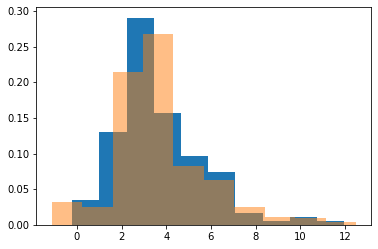

In [147]:
plt.hist([i[1] for i in data_y if i[0] and i[1] < 12.5], bins = 10, density=True)
plt.hist([i[1] for i in data_y if not i[0] and i[1] < 12.5], bins = 10, density=True, alpha=0.5)

In [148]:
# get concordance index of trained estimator
X_readm = data_x_numeric.loc[[i[0] for i in data_y]]
X_disch = data_x_numeric.loc[[not i[0] for i in data_y]]
y_readm = np.array([(True, i[1]) for i in data_y if i[0]], dtype=[('Status', '?'), ('Hrs_to_readmit', '<f8')])
y_disch = np.array([(True, i[1]) for i in data_y if not i[0]], dtype=[('Status', '?'), ('Hrs_to_readmit', '<f8')])

X_readm = X_readm.loc[:,X_readm.apply(pd.Series.nunique) != 1]
X_disch = X_disch.loc[:,X_disch.apply(pd.Series.nunique) != 1]

estimator_readm = CoxPHSurvivalAnalysis()
estimator_readm.fit(X_readm, y_readm)
prediction_readm = estimator_readm.predict(X_readm)
result_readm = concordance_index_censored(y_readm["Status"], y_readm["Hrs_to_readmit"], prediction_readm)
result_readm[0]

0.6714815497776958

In [149]:
x_train, x_test, y_train, y_test = train_test_split(X_readm, y_readm, test_size=0.2, random_state=0)

x_test = x_test.loc[:,x_train.apply(pd.Series.nunique) != 1]
x_train = x_train.loc[:,x_train.apply(pd.Series.nunique) != 1]

estimator_readm_split = CoxPHSurvivalAnalysis()
estimator_readm_split.fit(x_train, y_train)
# estimator.fit(x_train[x_train.columns[:180]], y_train)
prediction_readm_split = estimator_readm_split.predict(x_test)
result = concordance_index_censored(y_test["Status"], y_test["Hrs_to_readmit"], prediction_readm_split)
result[0]

0.5596518177163339

In [150]:
estimator_disch = CoxPHSurvivalAnalysis()
estimator_disch.fit(X_disch, y_disch)
prediction_disch = estimator_disch.predict(X_disch)
result_disch = concordance_index_censored(y_disch["Status"], y_disch["Hrs_to_readmit"], prediction_disch)
result_disch[0]

0.6294021165604355

In [151]:
x_train, x_test, y_train, y_test = train_test_split(X_disch, y_disch, test_size=0.2, random_state=0)

x_test = x_test.loc[:,x_train.apply(pd.Series.nunique) != 1]
x_train = x_train.loc[:,x_train.apply(pd.Series.nunique) != 1]

estimator_disch_split = CoxPHSurvivalAnalysis()
estimator_disch_split.fit(x_train, y_train)
# estimator.fit(x_train[x_train.columns[:180]], y_train)
prediction_disch_split = estimator_disch_split.predict(x_test)
result = concordance_index_censored(y_test["Status"], y_test["Hrs_to_readmit"], prediction_disch_split)
result[0]

0.6056576585362098

In [ ]:
# which variables are predictive?
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)

pd.set_option('display.max_rows', None)
print(pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False))
pd.reset_option('display.max_rows')

NameError: name 'x_test' is not defined

In [28]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(data_x_numeric,data_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [29]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(data_x_numeric, data_y)

cv_results = pd.DataFrame(gcv.cv_results_)

In [30]:
cv_results.to_csv('cvresultscox_readmit.csv')

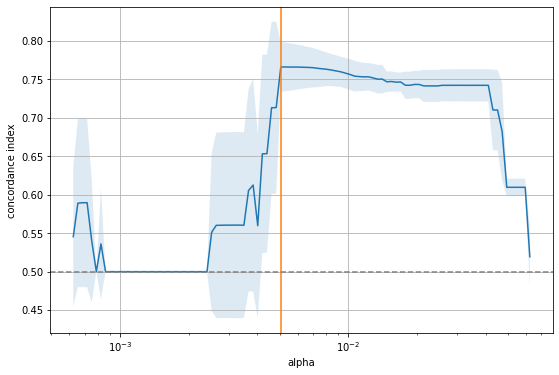

In [31]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)